In [7]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%pip install -U -q tensorflow-addons
!git clone https://github.com/polimi-ispl/icpr2020dfdc
!pip install efficientnet-pytorch
!pip install -U git+https://github.com/albu/albumentations > /dev/null
%cd icpr2020dfdc/notebook

Cloning into 'icpr2020dfdc'...
remote: Enumerating objects: 645, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 645 (delta 96), reused 80 (delta 80), pack-reused 537
Receiving objects: 100% (645/645), 99.63 MiB | 17.71 MiB/s, done.
Resolving deltas: 100% (336/336), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-0_pdaeo7
/content/icpr2020dfdc/notebook/icpr2020dfdc/notebook


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

import torch
from torch.utils.model_zoo import load_url
from PIL import Image
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import zipfile
import requests 
from pathlib import Path

from blazeface import FaceExtractor, BlazeFace
from architectures import fornet,weights
from isplutils import utils

In [10]:
%pip install image-dataset-loader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
#pip install --force-reinstall opencv-contrib-python==4.7.0.72

In [15]:
import cv2
from google.colab.patches import cv2_imshow  # Required to display images in Colab
import cv2
import numpy as np
from scipy.stats import kurtosis
import pywt
import numpy as np
import dlib
import os


# Define paths to real and fake images

basepath="drive/MyDrive/Deepfakes/Data/Task_1/faces_2/"
train_data_dir = "/content/drive/MyDrive/Deepfakes/Data/Task_1/faces_2/development"
validation_data_dir = "/content/drive/MyDrive/Deepfakes/Data/Task_2_3/faces_2/evaluation"
real_path = train_data_dir +"/real"
fake_path = train_data_dir +"/fake"

img_width, img_height = 436, 500

detector = dlib.get_frontal_face_detector()

predictor = dlib.shape_predictor("/content/drive/MyDrive/Deepfakes/models/shape_predictor_68_face_landmarks.dat")


def calc_three_best_features(img):
    """Input to this function should be a colored face crop"""

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    img = np.array(img, dtype=np.uint8)

    lap = cv2.Laplacian(img, cv2.CV_64F, ksize=3)
    lap = np.uint8(np.absolute(lap))
    gradient_amplitude = cv2.convertScaleAbs(lap)
    # titles = ['Approximation', ' Horizontal detail', 'Vertical detail', 'Diagonal detail']
    coeffs2 = pywt.dwt2(img, 'bior1.3')
    LL, (LH, HL, HH) = coeffs2
    return [np.mean(gradient_amplitude), np.var(LH)]



# Define a function to extract features from an image
def extract_features2(image):
    #gray = cv2.convertScaleAbs(image, alpha=(255.0 / 65535.0))
    img  = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Normalize the pixel values to the range [0, 255]
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    # Convert the pixel values from float32 to uint8 data type
    gray = np.array(img, dtype=np.uint8)
    features = []

    features.extend(calc_three_best_features(image))


    # Detect faces in the grayscale image
    faces = detector(gray)

    if len(faces) == 0:
        print('No faces detected')
        features.extend([0,0,0,0,0,0,0,0,0])
        return features

        return None
    elif len(faces) > 1:
        print('Multiple faces detected')
        return None
    else:
        print('One face detected')
        # Use the shape predictor model to get landmarks
        landmarks = predictor(gray, faces[0])
        # Convert landmarks to a numpy array
        landmarks = np.array([[p.x, p.y] for p in landmarks.parts()])

        for (x, y) in landmarks:
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
        #cv2.imshow('Landmarks', gray)

        # Calculate the distances between the left and right facial landmarks
        landmarks = np.squeeze(landmarks)

        eye_distances = [np.linalg.norm(landmarks[36] - landmarks[45]), np.linalg.norm(landmarks[42] - landmarks[47])]
        nose_width = np.linalg.norm(landmarks[31] - landmarks[35])
        mouth_width = np.linalg.norm(landmarks[48] - landmarks[54])
        features.extend([eye_distances[0], eye_distances[1], nose_width, mouth_width])

        
        left_eye_dist = np.linalg.norm(landmarks[36] - landmarks[39]) + np.linalg.norm(landmarks[37] - landmarks[38]) + np.linalg.norm(landmarks[40] - landmarks[41])
        right_eye_dist = np.linalg.norm(landmarks[42] - landmarks[45]) + np.linalg.norm(landmarks[43] - landmarks[44]) + np.linalg.norm(landmarks[46] - landmarks[47])
        nose_dist = np.linalg.norm(landmarks[31] - landmarks[35]) + np.linalg.norm(landmarks[32] - landmarks[34])
        mouth_dist = np.linalg.norm(landmarks[48] - landmarks[54]) + np.linalg.norm(landmarks[49] - landmarks[53]) + np.linalg.norm(landmarks[50] - landmarks[52]) + np.linalg.norm(landmarks[59] - landmarks[55]) + np.linalg.norm(landmarks[60] - landmarks[56]) + np.linalg.norm(landmarks[61] - landmarks[57])
        

        left_mouth_dist = np.linalg.norm(landmarks[48] - landmarks[54]) + np.linalg.norm(landmarks[49] - landmarks[53]) + np.linalg.norm(landmarks[50] - landmarks[52])
        right_mouth_dist = np.linalg.norm(landmarks[55] - landmarks[59]) + np.linalg.norm(landmarks[56] - landmarks[58]) + np.linalg.norm(landmarks[57] - landmarks[61])
        features.extend([right_mouth_dist, left_mouth_dist])

        # Calculate the symmetry ratio for each feature
        eye_symmetry = left_eye_dist / right_eye_dist
        mouth_symmetry = left_mouth_dist / right_mouth_dist

        # Add the symmetry ratios to the features list
        features.extend([mouth_symmetry, eye_symmetry]) #, nose_symmetry, mouth_symmetry])

        # Calculate the distances between facial landmarks that correspond to specific expressions
        smile_dist = np.linalg.norm(landmarks[48] - landmarks[54]) + np.linalg.norm(landmarks[49] - landmarks[53]) + np.linalg.norm(landmarks[50] - landmarks[52])

        # Add the expression distances to the features list
        features.extend([smile_dist])

        left_eye = landmarks[36:42]
        right_eye = landmarks[42:48]

        # Compute the center of each eye region
        left_eye_center = np.mean(left_eye, axis=0).astype(int)
        right_eye_center = np.mean(right_eye, axis=0).astype(int)

        # Compute the horizontal and vertical distance between the eye centers
        dx = right_eye_center[0] - left_eye_center[0]
        dy = right_eye_center[1] - left_eye_center[1]

        # Compute the angle of the line between the eye centers
        #angle = np.arctan2(dy, dx) * 180 / np.pi ###########################################################
        #features.append(angle)

        #do fft for gray img
        fft = np.fft.fft2(gray, s=[100,100], norm="ortho").reshape(1,-1)
        fft = np.absolute(fft).tolist()[0] #take magnitude and convert to list


        return features  #+ fft


train_data_generator =ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    brightness_range=[0.5, 1.5],
    channel_shift_range=50,
    zoom_range=0.2)

train_generator = train_data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode='binary',
        color_mode='rgb')

# Iterate over the training images and extract features
train_features = []
train_labels = []
i = 0


num_images = len(train_generator.filenames)  # get total number of images in the dataset
counter = 0  # initialize a counter

for image, label in train_generator:
    image = image[0]  # handle 1 element batch
    label = int(label[0])
    features = extract_features2(image)
    if features:
        train_features.append(features)
        temp = [0, 0]
        temp[label] = 1
        train_labels.append(temp)
    counter += 1  # increment the counter
    if counter == num_images:  # break out of the loop when all images have been processed
        break

train_features = np.array(train_features)
train_labels = np.array(train_labels)

# Do the same for the validation set
validation_data_generator = ImageDataGenerator(rescale=1./255)

validation_generator = validation_data_generator.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode='binary')

counter = 0  # initialize a counter
num_images = len(validation_generator.filenames)  # get total number of images in the dataset

validation_features = []
validation_labels = []
for image, label in validation_generator:
    image = image[0]  # handle 1 element batch
    label = int(label[0])
    features = extract_features2(image)
    if features:
        validation_features.append(features)
        temp = [0, 0]
        temp[label] = 1
        validation_labels.append(temp)
    counter += 1  # increment the counter
    if counter == num_images:  # break out of the loop when all images have been processed
        break

validation_features = np.array(validation_features)
validation_labels = np.array(validation_labels)



/content/drive/MyDrive/Deepfakes/Data/Task_1/faces_2/development
Found 758 images belonging to 2 classes.
One face detected
One face detected
One face detected
No faces detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
No faces detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
No faces detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face detected
One face det

In [19]:
tffilename = "train_features_task2.npy"
tlfilename = "train_labels_task2.npy"
vffilename = "validation_task2.npy"
vlfilename = "validation_label_task2.npy"

np.save(tffilename, train_features)
np.save(tlfilename, train_labels)
np.save(vffilename, validation_features)
np.save(vlfilename, validation_labels)
"helloWorld"

'helloWorld'

In [25]:
import tensorflow as tf
import numpy as np

#handcrafted_features_train = np.load('/content/' + tffilename ,allow_pickle=True)#.reshape((-1, 10004))
#train_labels = np.load('/content/' + tlfilename)#.reshape((-1,2))
#handcrafted_features_val = np.load('/content/' + vffilename ,allow_pickle=True)#.reshape((-1, 10004))
#val_labels = np.load('/content/' + vlfilename)#.reshape((-1,2))

print(train_features.shape)

  

"""
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
handcrafted_features_train = scaler.fit_transform(handcrafted_features_train)
handcrafted_features_val = scaler.transform(handcrafted_features_val)
"""
#val_labels = np.argmax(val_labels, axis = 1)
##train_labels = np.argmax(train_labels, axis = 1)

print(train_labels.shape)
print(validation_labels.shape)
    

# Define the data generators for train and validation sets
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((validation_features, validation_labels))

input_shape = (11)

model = Sequential([
    tf.keras.Input(shape=input_shape, name="input_layer"),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(900, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(800, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003),
              metrics=['accuracy'])
history = model.fit(train_dataset.batch(16),
                    epochs=200,
                    validation_data=val_dataset.batch(16))

# Calculate the loss and accuracy on the validation set
val_loss, val_acc = model.evaluate(val_dataset.batch(16))
print('Validation loss:', val_loss)
print('Validation accuracy:', val_acc)

(758, 11)
(758, 2)
(600, 2)
Epoch 1/200
48/48 [==============================] - 7s 8ms/step - loss: 1.7661 - accuracy: 0.4683 - val_loss: 1.0411 - val_accuracy: 0.5017
Epoch 2/200
48/48 [==============================] - 0s 8ms/step - loss: 1.4018 - accuracy: 0.5501 - val_loss: 0.8070 - val_accuracy: 0.5067
Epoch 3/200
48/48 [==============================] - 0s 6ms/step - loss: 1.3508 - accuracy: 0.4987 - val_loss: 1.0323 - val_accuracy: 0.4967
Epoch 4/200
48/48 [==============================] - 0s 5ms/step - loss: 1.3595 - accuracy: 0.5092 - val_loss: 1.0867 - val_accuracy: 0.4967
Epoch 5/200
48/48 [==============================] - 0s 5ms/step - loss: 1.2008 - accuracy: 0.5158 - val_loss: 0.7033 - val_accuracy: 0.5617
Epoch 6/200
48/48 [==============================] - 0s 5ms/step - loss: 1.1293 - accuracy: 0.5330 - val_loss: 0.7779 - val_accuracy: 0.4983
Epoch 7/200
48/48 [==============================] - 0s 5ms/step - loss: 1.1123 - accuracy: 0.5132 - val_loss: 0.7851 - val_ac

In [31]:
#Load new model
device = "cuda" if torch.cuda.is_available() else "cpu"
face_policy = 'scale'
face_size = 224
train_db = 'FFPP'
net_model = 'EfficientNetAutoAttB4'
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetAutoAttB4_FFPP_bestval-b0c9e9522a7143cf119843e910234be5e30f77dc527b1b427cdffa5ce3bdbc25.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetAutoAttB4_FFPP_bestval-b0c9e9522a7143cf119843e910234be5e30f77dc527b1b427cdffa5ce3bdbc25.pth


HTTPError: ignored

In [ ]:

pred_labels=[]
for image, label in validation_generator:
    image = image[0]  # handle 1 element batch
    label = int(label[0])
    features = extract_features2(image)
    if features:
        validation_features.append(features)
        temp = [0, 0]
        temp[label] = 1
        validation_labels.append(temp)
    counter += 1  # increment the counter
    if counter == num_images:  # break out of the loop when all images have been processed
        break

for input in val_dataset:
  model.predict(np.array([input[0],]),verbose=False)
  break

tf.Tensor(
[ 22.11620183  36.88863708 201.30076999  18.43908891  58.13776741
 127.19276709 150.82231026 238.48272664   1.58121651   0.9019159
 238.48272664], shape=(11,), dtype=float64)


19/19 [==============================] - 0s 5ms/step
[ 1.58787370e-01  4.27144885e-01  9.08175707e-02  6.79778695e-01
  6.74945474e-01  2.69513607e-01  3.09369087e-01  5.72354078e-01
  3.76600385e-01  2.32374430e-01  1.58001542e-01  4.01982546e-01
  2.23195910e-01  3.72304678e-01  1.50740147e-02  1.80992007e-01
  4.15686369e-01  1.07676983e-01  2.82342434e-02  5.12777090e-01
  6.80409431e-01  6.56388640e-01  4.22696829e-01  6.42091632e-01
  2.00347185e-01  2.96838284e-01  4.95946407e-03  2.46076226e-01
  2.62750149e-01  4.16757345e-01  5.42320967e-01  2.64099956e-01
  3.99427295e-01  6.93840623e-01  2.17254758e-01  5.09857059e-01
  3.01709890e-01  3.91266227e-01  3.43581676e-01  2.85286307e-01
  1.57043457e-01  1.73562765e-01  3.17444444e-01  5.85322261e-01
  4.72068310e-01  1.17805958e-01  3.21135402e-01  7.82017708e-01
  2.88130045e-01  3.96090031e-01  1.25285387e-01  8.06893110e-01
  5.43557167e-01  5.65418720e-01  1.50680423e-01  8.07129741e-01
  5.40351033e-01  2.37276316e-01  5.8

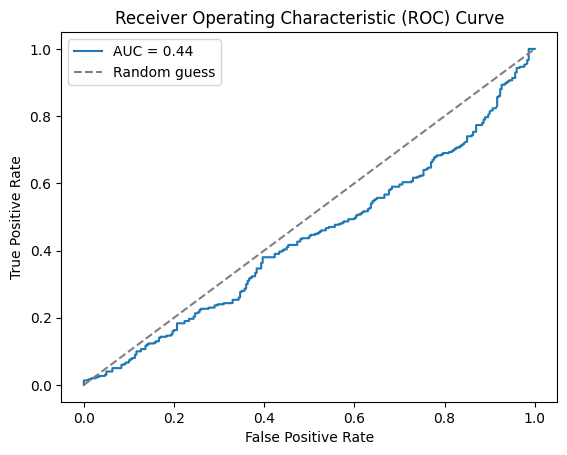

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
faces_pred = model.predict(handcrafted_features_val)
faces_pred = (np.amax(faces_pred, axis = 1)-0.5)*2
val_labels = np.argmax(val_labels, axis = 1)
print(faces_pred)


fpr, tpr, thresholds = roc_curve(val_labels, faces_pred)

# Compute area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()